# `NoEpistasisBottleneckLikelihood` model
Simulates some variants and analyzes them under the `globalepistasis.NoEpistasisBottleneckLikelihood` model.

This notebook is designed as a test, not for user documentation--and it uses some private methods that should not be used in real analyses.

## Set up
Import Python modules:

In [1]:
import copy
import math
import random
import time
import warnings

import numpy

import pandas as pd

from plotnine import *

import scipy

import dms_variants.binarymap
import dms_variants.globalepistasis
import dms_variants.codonvarianttable
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

Parameters for simulations:

In [2]:
seed = 1  # random number seed
genelength = 25  # gene length in codons
bclen = 16  # length of barcodes
libs = ['lib_1', 'lib_2']  # distinct libraries of gene
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.5  # average codon mutations per variant
variant_error_rate = 0  # rate variants are mis-sequenced
depth = 1000 * variants_per_lib  # per-sample sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.0  # non-statistical noise in selections
bottleneck = variants_per_lib * 5
bottlenecks = {  # bottlenecks from pre- to post-selection
        'loose_bottle': bottleneck,
        }

Seed random number generators:

In [3]:
random.seed(seed)
scipy.random.seed(seed)

Suppress warnings that clutter output:

In [4]:
warnings.simplefilter('ignore')

## Simulate variants
Simulate wildtype gene sequence:

In [5]:
geneseq = ''.join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 25 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATC


Simulate a `CodonVariantTable`:

In [6]:
variants = dms_variants.simulate.simulate_CodonVariantTable(
                geneseq=geneseq,
                bclen=bclen,
                library_specs={lib: {'avgmuts': avgmuts,
                                     'nvariants': variants_per_lib}
                               for lib in libs},
                seed=seed,
                )

Number of amino-acid mutations per variant in library:

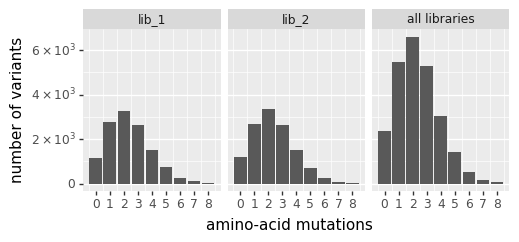

In [7]:
p = variants.plotNumMutsHistogram('aa', samples=None, max_muts=8)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Simulate variant counts
We will simulate using a `SigmoidPhenotypeSimulator`:

In [8]:
phenosimulator = dms_variants.simulate.SigmoidPhenotypeSimulator(
                    geneseq,
                    seed=seed,
                    norm_weights=((0.4, -0.5, 0.7), (0.6, -5, 1.5)),
                    stop_effect=-9,
                    )

But since we are using a non-epistatic (linear model), we will simulate variants according to the *latent phenotype* rather than their *observed phenotype* (since in a non-epistatic model these two are the same).
First, look at the distribution of latent phenotypes for all single mutants (the dashed orange line is the latent phenotype of wildtype):

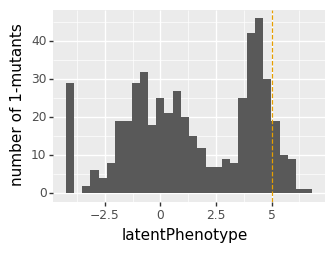

In [9]:
p = phenosimulator.plotMutsHistogram('latentPhenotype')
_ = p.draw()

Our simulation function is then the exponential of the latent phenotype, as mutants as the functional scores represent the log enrichment:

In [10]:
def phenotype_func(x):
    return math.exp(phenosimulator.latentPhenotype(x))

Now we simulate the counts, passing to the simulate function the latent rather than observed phenotype:

In [11]:
counts = dms_variants.simulate.simulateSampleCounts(
            variants=variants,
            phenotype_func=phenotype_func,
            variant_error_rate=variant_error_rate,
            pre_sample={'total_count': depth,
                        'uniformity': lib_uniformity},
            pre_sample_name='pre-selection',
            post_samples={name: {'noise': noise,
                                 'total_count': depth,
                                 'bottleneck': bottle}
                          for name, bottle in bottlenecks.items()},
            seed=seed,
            )

Add the counts to the variant table:

In [12]:
variants.add_sample_counts_df(counts)

Confirm expected selection on mutations:

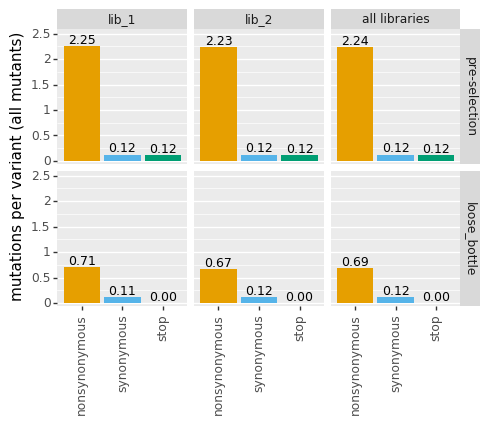

In [13]:
p = variants.plotNumCodonMutsByType('all')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Get functional scores
Get the functional scores:

In [14]:
func_scores = variants.func_scores('pre-selection', libraries=variants.libraries)

Classify the functional scores:

In [15]:
func_scores = variants.classifyVariants(func_scores)

Use `plotnine` to plot distribution of functional scores:

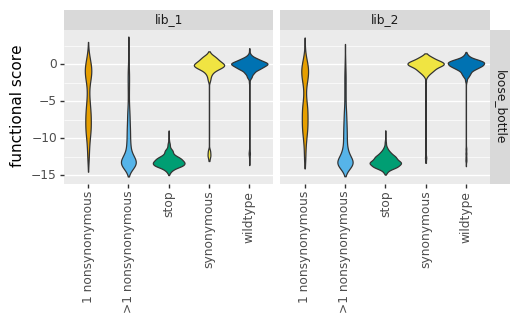

In [16]:
p = (
    ggplot(func_scores, aes('variant_class', 'func_score')) +
    geom_violin(aes(fill='variant_class')) +
    ylab('functional score') +
    xlab('') +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(2.75 * len(libs),
                       2 * len(bottlenecks)),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank(),  # no vertical grid lines
          ) +
    scale_fill_manual(values=CBPALETTE[1 :], guide=False)
    )
_ = p.draw()

## Initialize model

Make a binary map for the variants:

In [17]:
binarymap = dms_variants.binarymap.BinaryMap(func_scores)
print(f"Length of binary map is {binarymap.binarylength}")

Length of binary map is 500


Now initialize the `NoEpistasisBottleneckLikelihood` model:

In [18]:
model = dms_variants.globalepistasis.NoEpistasisBottleneckLikelihood(binarymap,
                                                                     bottleneck=bottleneck)

Look at some model attributes:

In [19]:
model.nparams

501

In [20]:
for param, val in model.likelihood_calc_params_dict.items():
    print(f"{param}: {val:.3f}")

In [21]:
assert scipy.allclose(model.loglik,
                      -116908,
                      rtol=0.01,
                      atol=3), model.loglik

In [22]:
model.latent_phenotype_wt()

0.0

Check the analytical gradient versus numerical approximation, and make sure the difference is small compared to total gradient:

In [23]:
err = scipy.optimize.check_grad(
            model._loglik_by_allparams,
            model._dloglik_by_allparams,
            model._allparams)
tot = math.sqrt(sum(model._dloglik_by_allparams(model._allparams)**2))
if err / tot > 1e-5:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

## Initial least squares fitting
Perform initial least squares optimization (normally this is actually performed by the `fit` method):

In [24]:
_ = model._fit_latent_leastsquares()

Re-check the gradients:

In [25]:
err = scipy.optimize.check_grad(
            model._loglik_by_allparams,
            model._dloglik_by_allparams,
            model._allparams)
tot = math.sqrt(sum(model._dloglik_by_allparams(model._allparams)**2))
if err / tot > 1e-3:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

In [26]:
assert scipy.allclose(model.loglik,
                      -1072778,
                      rtol=0.01,
                      atol=3), model.loglik

In [27]:
r, p = scipy.stats.pearsonr(
        binarymap.func_scores,
        model.phenotypes_frombinary(binarymap.binary_variants, 'latent'),
        )
print(f"R = {r:.1f}, P = {p:.2g}")

R = 0.8, P = 0


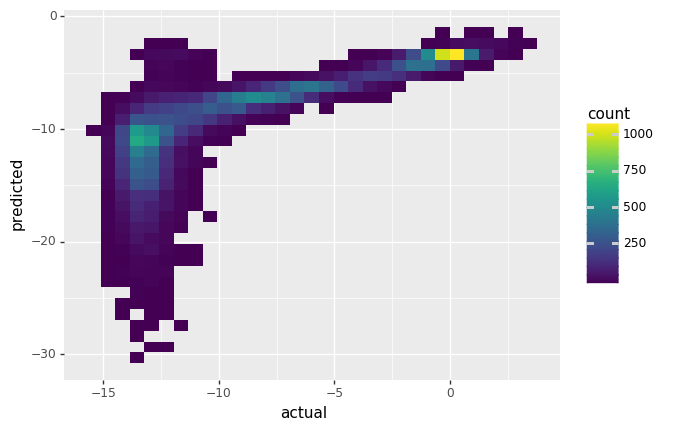

In [28]:
df = pd.DataFrame({'actual': binarymap.func_scores,
                   'predicted': model.phenotypes_frombinary(binarymap.binary_variants, 'latent'),
                   })

_ = (ggplot(df, aes('actual', 'predicted')) +
     geom_bin2d()
     ).draw()

In [29]:
for param, val in model.likelihood_calc_params_dict.items():
    print(f"{param}: {val:.3f}")

In [30]:
round(model.latent_phenotype_wt(), 1)

-3.6

## Fit the full model

Now fit the model by maximum likelihood.


In [31]:
# NBVAL_IGNORE_OUTPUT
start = time.time()
optres = model.fit()
print(f"Fitting took {time.time() - start:.3f} seconds")

Fitting took 0.570 seconds


In [32]:
assert scipy.allclose(model.loglik,
                      -54492,
                      rtol=0.01,
                      atol=3), model.loglik

In [33]:
for param, val in model.likelihood_calc_params_dict.items():
    print(f"{param}: {val:.3f}")

In [34]:
round(model.latent_phenotype_wt(), 3)

0.0

In [35]:
r, p = scipy.stats.pearsonr(
        binarymap.func_scores,
        model.phenotypes_frombinary(binarymap.binary_variants, 'latent'),
        )
print(f"R = {r:.1f}, P = {p:.2g}")

R = 0.7, P = 0


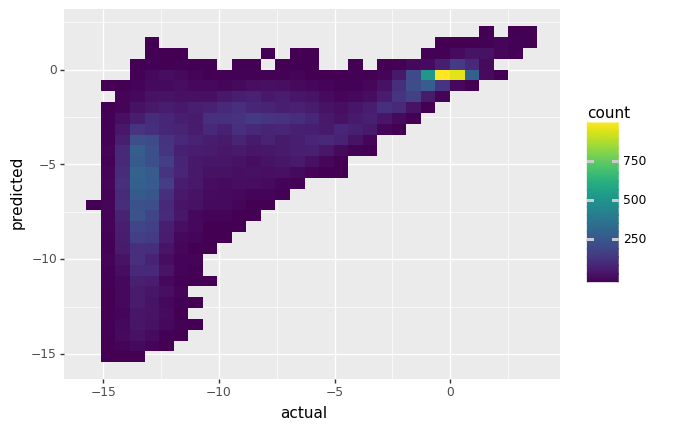

In [36]:
df = pd.DataFrame({'actual': binarymap.func_scores,
                   'predicted': model.phenotypes_frombinary(binarymap.binary_variants, 'latent'),
                   })

_ = (
     ggplot(df, aes('actual', 'predicted')) +
     geom_bin2d()
     ).draw()